In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

%cd "C:\Users\jdhare\Documents\GitHub\turbulence_tracing\particle_tracking"
import ray_transfer_matrix as rtm
import particle_tracker as pt

C:\Users\jdhare\Documents\GitHub\turbulence_tracing\particle_tracking


In [2]:
## Create the coordiantes for a cube with 201x201x201 cells, 
## and attach a [-5,5] mm coordinate system to them.

N_V = 100
M_V = 2*N_V+1
extent = 5.0e-3
x = np.linspace(-extent,extent,M_V)
y = np.linspace(-extent,extent,M_V)
z = np.linspace(-extent,extent,M_V)

## Null test
Empty cube: no deflection. Some divergence in the initial beam causes "fuzzy" edges in the output beam

In [3]:
null = pt.ElectronCube(x,y,z)
null.test_null()
null.calc_dndr()

### Initialise rays
null.init_beam(Np = 100000, beam_size= 2e-3, divergence = 5e-3)

Ray trace completed in:	 1.86295485496521 s


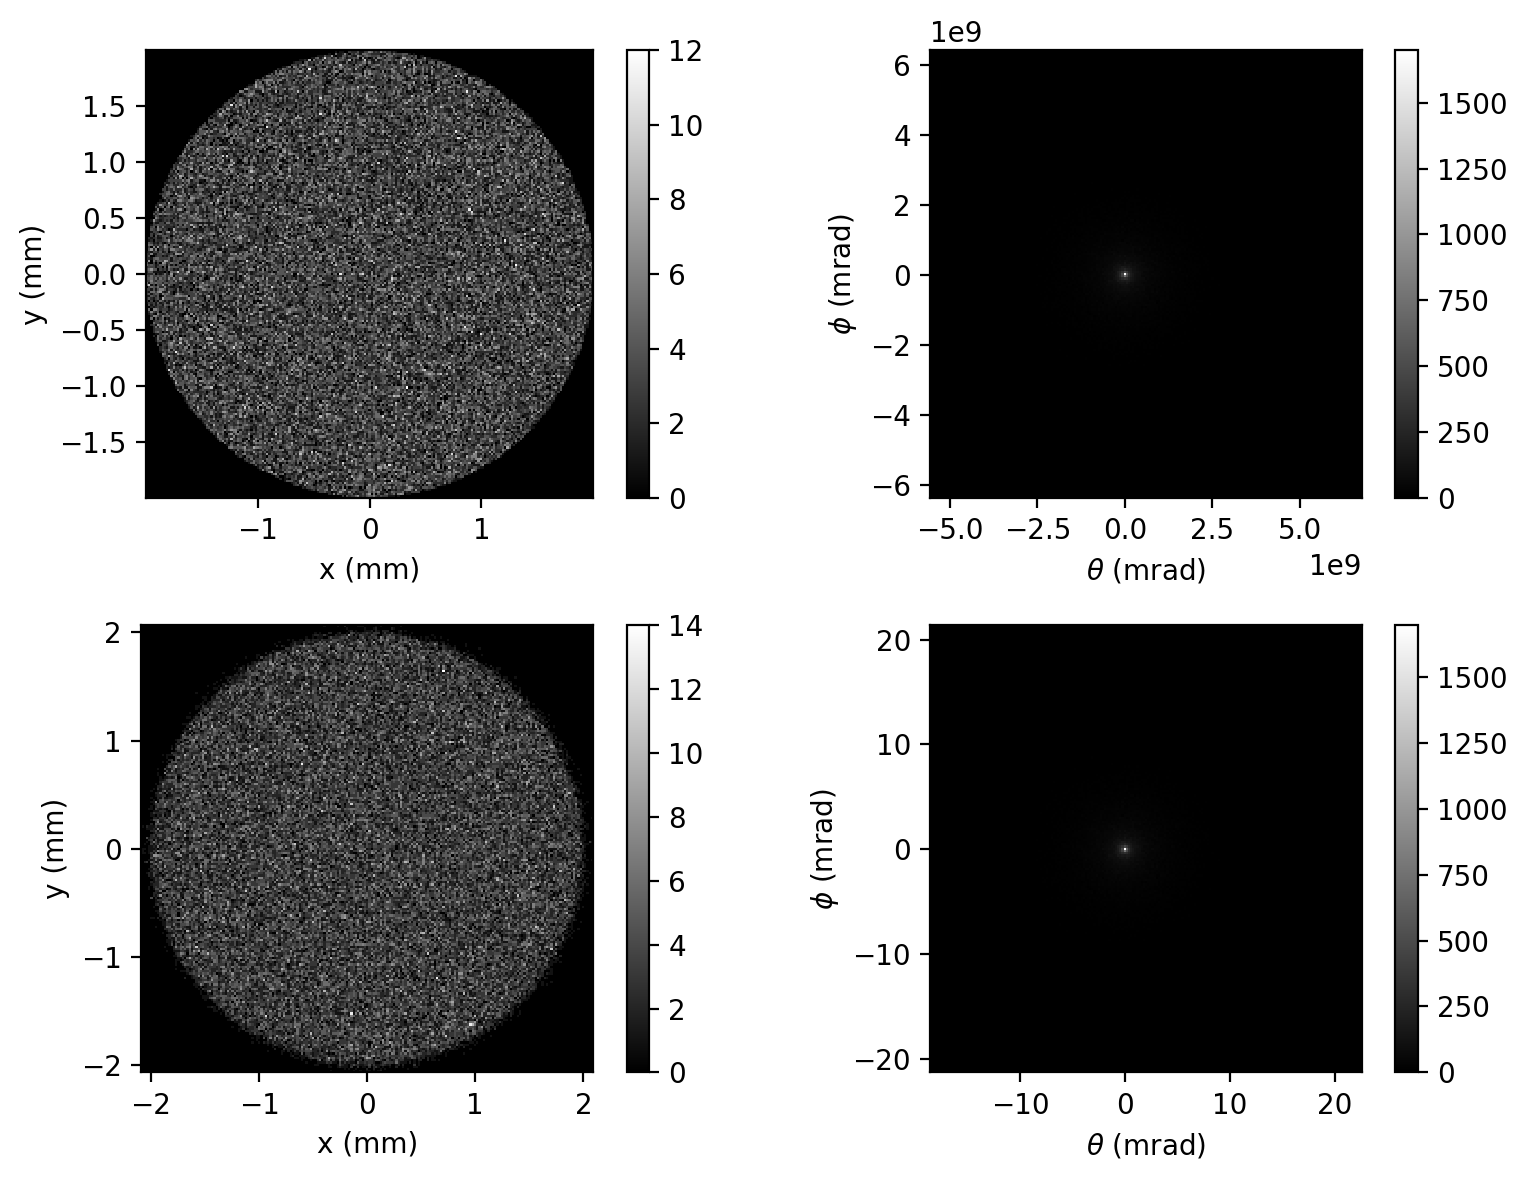

In [4]:
### solve
null.solve()
s0 = null.s0
rf = null.rf

### Plot
fig, axs = plt.subplots(2, 2, figsize=(8,6), dpi = 200)
nbins = 201

ax1 = axs[0,0]
_,_,_,im1 = ax1.hist2d(s0[0]*1e3, s0[1]*1e3, bins=(nbins, nbins), cmap='gray');
plt.colorbar(im1,ax=ax1)
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_aspect('equal')

ax2 = axs[0,1]
_,_,_,im2 = ax2.hist2d(s0[3]*1e3, s0[4]*1e3, bins=(nbins, nbins), cmap='gray');
plt.colorbar(im2,ax=ax2)
ax2.set_xlabel(r"$\theta$ (mrad)")
ax2.set_ylabel(r"$\phi$ (mrad)")
ax2.set_aspect('equal')

ax3 = axs[1,0]
_,_,_,im3 = ax3.hist2d(rf[0]*1e3, rf[2]*1e3, bins=(nbins, nbins), cmap='gray');
plt.colorbar(im3,ax=ax3)
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")
ax3.set_aspect('equal')

ax4 = axs[1,1]
_,_,_,im4 = ax4.hist2d(rf[1]*1e3, rf[3]*1e3, bins=(nbins, nbins), cmap='gray');
plt.colorbar(im4,ax=ax4)
ax4.set_xlabel(r"$\theta$ (mrad)")
ax4.set_ylabel(r"$\phi$ (mrad)")
ax4.set_aspect('equal')


fig.tight_layout()

Note that the beam has not moved in real space, and the rays have not changed angle. The edge of the beam is slightly fuzzy due to the randomly chosen beam angle, chosen uniformly within the interval [0, 5] mrad.

## SLAB TEST: Deflect rays in negative x-direction

In [5]:
slab = pt.ElectronCube(x,y,z)
slab.test_slab(s=8, n_e0=1e25)
slab.calc_dndr()

## Initialise rays and solve
slab.init_beam(Np = 100000, beam_size=2e-3, divergence = 10e-3)
slab.solve()
s0 = slab.s0
rf = slab.rf

Ray trace completed in:	 4.639532804489136 s


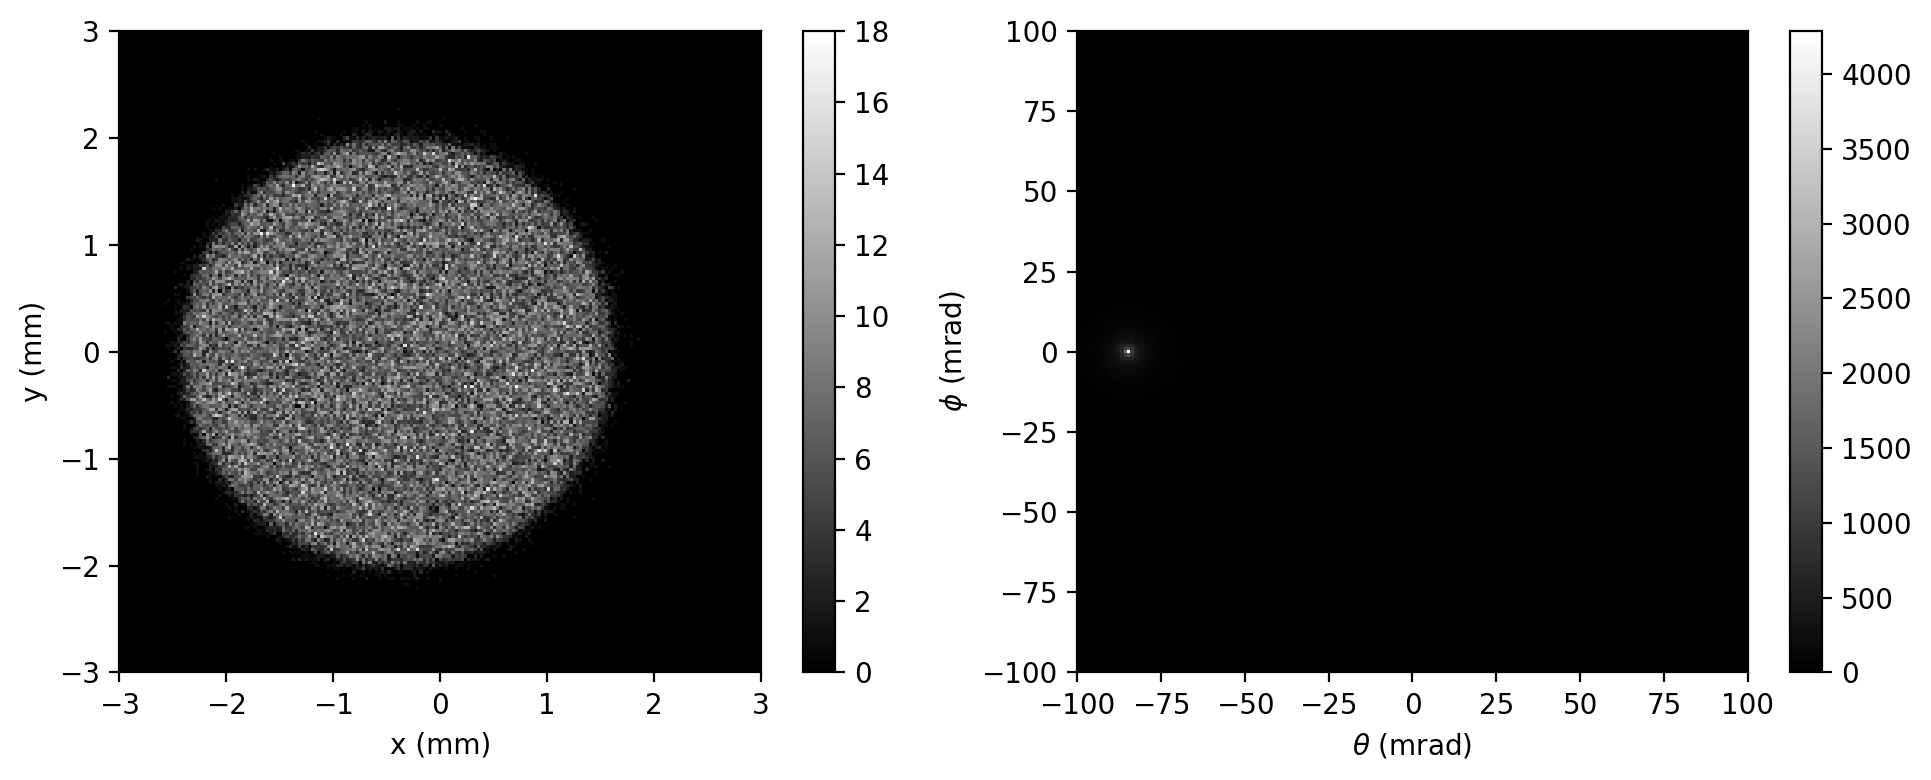

In [6]:
## Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), dpi = 200)
nbins = 201

_,_,_,im1 = ax1.hist2d(rf[0]*1e3, rf[2]*1e3, bins=(nbins, nbins), range = ((-3,3), (-3,3)), cmap=plt.cm.gray);
plt.colorbar(im1,ax=ax1)
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_aspect('equal')

_,_,_,im2 = ax2.hist2d(rf[1]*1e3, rf[3]*1e3, bins=(nbins, nbins), range = ((-100,100), (-100,100)), cmap=plt.cm.gray);
plt.colorbar(im2,ax=ax2)
ax2.set_xlabel(r"$\theta$ (mrad)")
ax2.set_ylabel(r"$\phi$ (mrad)")
ax1.set_aspect('equal')

fig.tight_layout()

Note that the beam has deflected to the left by around 0.5 mm. The rays are now all at an angle of around 80 mrad. A stronger gradient would deflect the beam further, as can be readily tested.

## Lens test
Create an azimuthally symmetric Gaussian distribution of density with its axis aligned along the probing axis. This acts as a diverging lens.

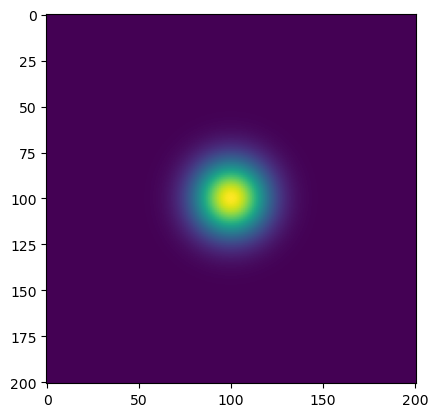

In [31]:
lens = pt.ElectronCube(x,y,z)
lens.test_lens(n_e0 = 5e25, LR = 1e-3)
fig, ax  = plt.subplots()
ax.imshow(lens.ne[:,:, 0], clim = [0, 5e25])

In [32]:
lens.calc_dndr()

## Initialise rays and solve
lens.init_beam(Np = 1000000, beam_size=3e-3, divergence = 10e-3)
lens.solve()
s0 = lens.s0
rf = lens.rf

Ray trace completed in:	 84.11229848861694 s


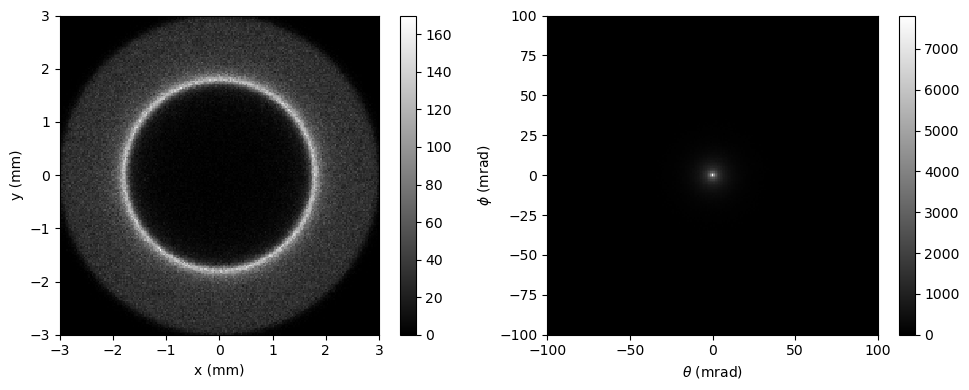

In [33]:
## Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
nbins = 201

_,_,_,im1 = ax1.hist2d(rf[0]*1e3, rf[2]*1e3, bins=(nbins, nbins), range = ((-3,3), (-3,3)), cmap=plt.cm.gray);
plt.colorbar(im1,ax=ax1)
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_aspect('equal')

_,_,_,im2 = ax2.hist2d(rf[1]*1e3, rf[3]*1e3, bins=(nbins, nbins), range = ((-100,100), (-100,100)), cmap=plt.cm.gray);
plt.colorbar(im2,ax=ax2)
ax2.set_xlabel(r"$\theta$ (mrad)")
ax2.set_ylabel(r"$\phi$ (mrad)")
ax1.set_aspect('equal')

fig.tight_layout()

In the center, where there are significant density gradients, the rays are diverging. Outside the region where the Gaussian has steep slopes, the density gradients are small and most rays travel in striaght lines - these are represented by the unperturbed areas in the region with R > 2 mm in real space, or the ways with very small deflection angles. The bright ring structure is made by the rays with non-zero angle.

## Ray Transfer Matrices
Define three diagnostics, all with an identical two-lens 1:1 image relay. One has no stops (shadowgraphy), one has a circular stop (dark field schlieren imaging) at the focal point and one has a circular aperture at the focal point (light field schlieren imaging).

In [52]:
sh = rtm.Shadowgraphy(r0 = lens.rf, focal_plane = 0, L=400, R=25, Lx=6, Ly=6)
sc_df = rtm.Schlieren_DF(r0 = lens.rf, focal_plane = 0, L=400, R=25, Lx=6, Ly=6)
sc_lf = rtm.Schlieren_LF(r0 = lens.rf, focal_plane = 0, L=400, R=25, Lx=6, Ly=6)

In [53]:
sh.solve()
sc_df.solve(R = 3)
sc_lf.solve(R = 3)

Text(0.5, 1.0, 'LF + DF schlieren')

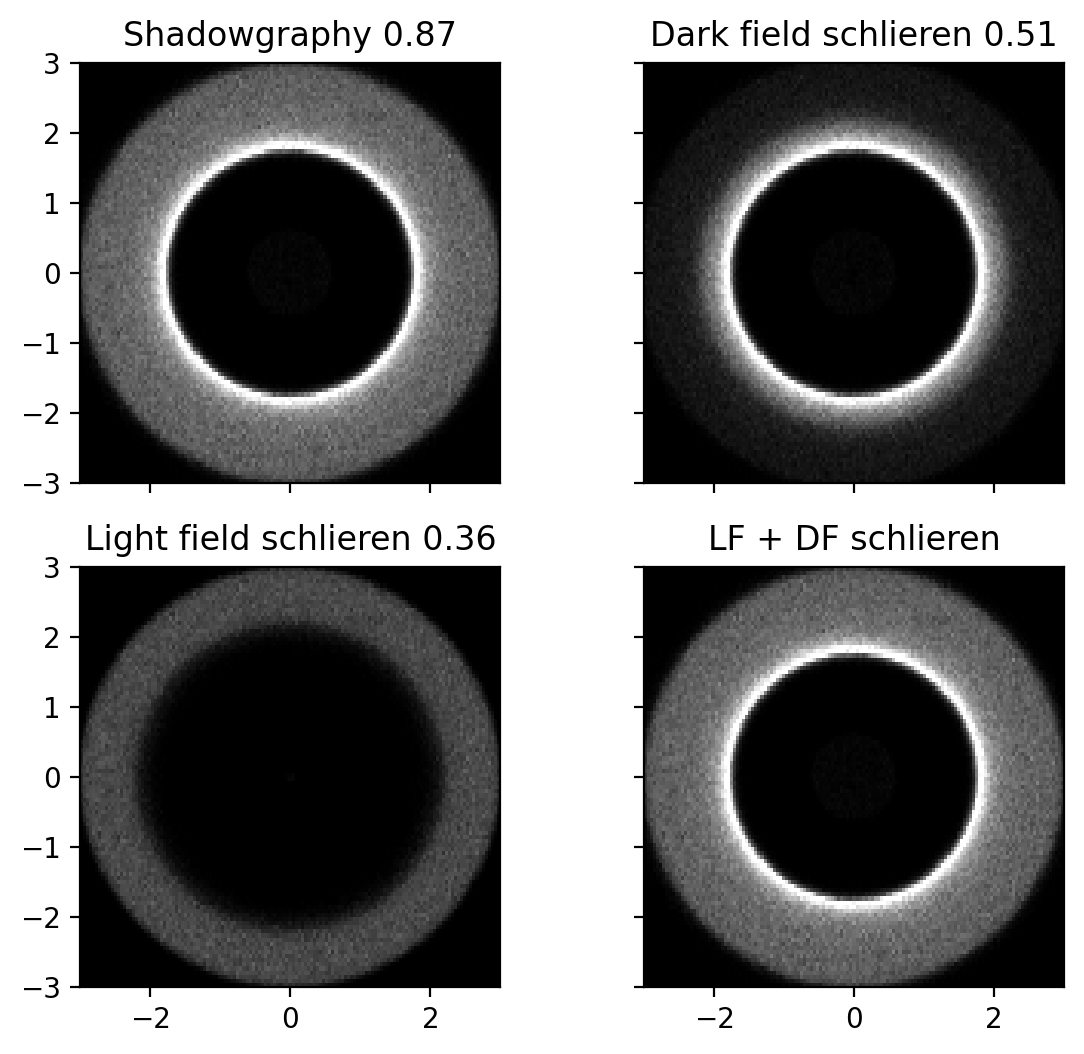

In [54]:
sh.histogram(bin_scale = 25)
sc_df.histogram(bin_scale = 25)
sc_lf.histogram(bin_scale = 25)

fig, axs = plt.subplots(2,2, figsize=(6.67, 6), sharex = True, sharey = True, dpi = 200)

cm='gray'
clim=[0,250]

sh.plot(axs[0,0], clim=clim, cmap=cm)
axs[0,0].set_title('Shadowgraphy {:.2f}'.format(sh.H.sum()/1e6))
sc_df.plot(axs[0,1], clim=clim, cmap=cm)
axs[0,1].set_title('Dark field schlieren {:.2f}'.format(sc_df.H.sum()/1e6))
sc_lf.plot(axs[1,0], clim=clim, cmap=cm)
axs[1,0].set_title('Light field schlieren {:.2f}'.format(sc_lf.H.sum()/1e6))

axs[1,1].imshow(sc_lf.H+sc_df.H, interpolation='nearest', origin='lower', clim=clim, cmap=cm,
                extent=[sh.xedges[0], sh.xedges[-1], sh.yedges[0], sh.yedges[-1]])
axs[1,1].set_title('LF + DF schlieren')

These are the images formed on the detectors after the ray transfer matrix procedure. A binning of 25x25 pixels is used to reduce signal to noise. The sum of the dark field and light field diagnostics is the shadowgraphy, as expected.

Note that due to finite aperture effects, the shadowgraphy does not reproduce the image at the end of the cube produced by the ray tracer. Some of the rays are at such large angles that they are lost to the numerical aperture of the system. This can readily verified by changing the length scale L of the optical system to something short, like 1 mm - all the rays will then be captured, and the ratio will be 1.0.

## A liner
Really an axisymmetric normal distribution with the axis normal to the propagation direction. To test densities greater than the critical density, which can conviniently be calculated below:

In [55]:
lwl = 1053e-9
ω = 2*np.pi*(3e8/lwl)
n_c = 3.14207787e-4*ω**2
print(n_c)

1.006844605946948e+27


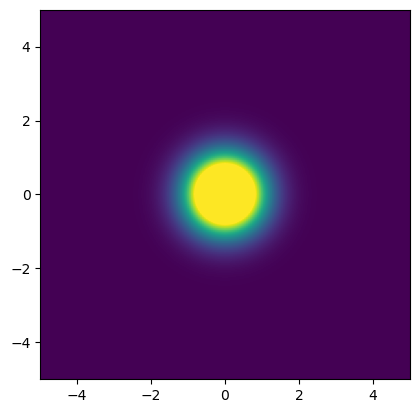

In [56]:
liner = pt.ElectronCube(x,y,z)
liner.test_liner(n_e0 = 2e27, LR = 1e-3)
fig, ax  = plt.subplots()
ax.imshow(liner.ne[:,0, :], clim = [0, n_c], extent = [-5,5,-5,5])

In [57]:
liner.calc_dndr()

## Initialise rays and solve
liner.init_beam(Np = 100000, beam_size=5e-3, divergence = 2e-3)
liner.solve()
s0 = liner.s0
rf = liner.rf

Ray trace completed in:	 19.602821111679077 s


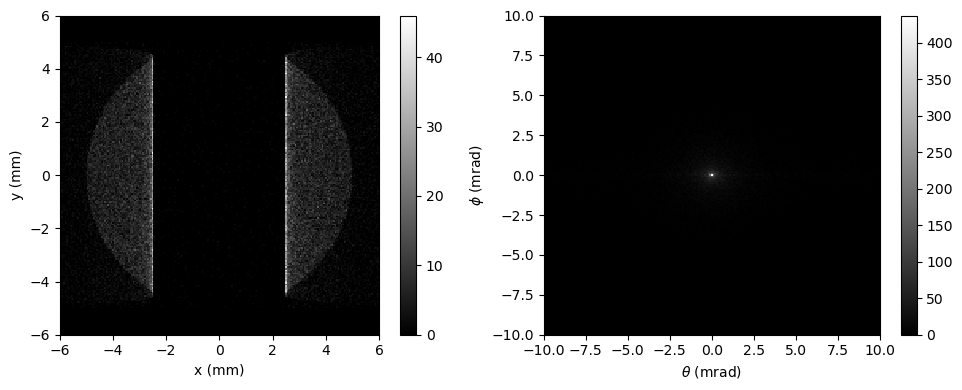

In [58]:
## Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
nbins = 201

_,_,_,im1 = ax1.hist2d(rf[0]*1e3, rf[2]*1e3, bins=(nbins, nbins), range = ((-6,6), (-6,6)), cmap=plt.cm.gray);
plt.colorbar(im1,ax=ax1)
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_aspect('equal')

_,_,_,im2 = ax2.hist2d(rf[1]*1e3, rf[3]*1e3, bins=(nbins, nbins), range = ((-10,10), (-10,10)), cmap=plt.cm.gray);
plt.colorbar(im2,ax=ax2)
ax2.set_xlabel(r"$\theta$ (mrad)")
ax2.set_ylabel(r"$\phi$ (mrad)")
ax1.set_aspect('equal')

fig.tight_layout()

We see a dark void at the center of the image, inside which rays have been have been refracted out. Note that the region in which n_e > n_c is only 1 mm in radius, and the void is twice as large as this - the void is not just caused by rays being block, but by rays being deflected.

In [18]:
x_max = np.abs(rf[0]).max()*1e3
theta_max = np.abs(rf[1]).max()
print("Furthest deflected ray: {:.2f} mm. Largest ray angle: {:.2f} radians".format(x_max, theta_max))

Furthest deflected ray: 317347.71 mm. Largest ray angle: 1.57 radians


As you can see, some rays are defleced by 90'. Ray tracing is no longer a good approximation here, but the rays will never make it to the detector. 

In [75]:
sh = rtm.Shadowgraphy(r0 = liner.rf, focal_plane = 0, L=50, R=25, Lx=15, Ly=10)
sc_df = rtm.Schlieren_DF(r0 = liner.rf, focal_plane = 0, L=50, R=25, Lx=15, Ly=10)
sc_lf = rtm.Schlieren_LF(r0 = liner.rf, focal_plane = 0, L=50, R=25, Lx=15, Ly=10)

In [82]:
sh.solve()
sc_df.solve(R = 2)
sc_lf.solve(R = 2)

Text(0.5, 1.0, 'LF + DF schlieren')

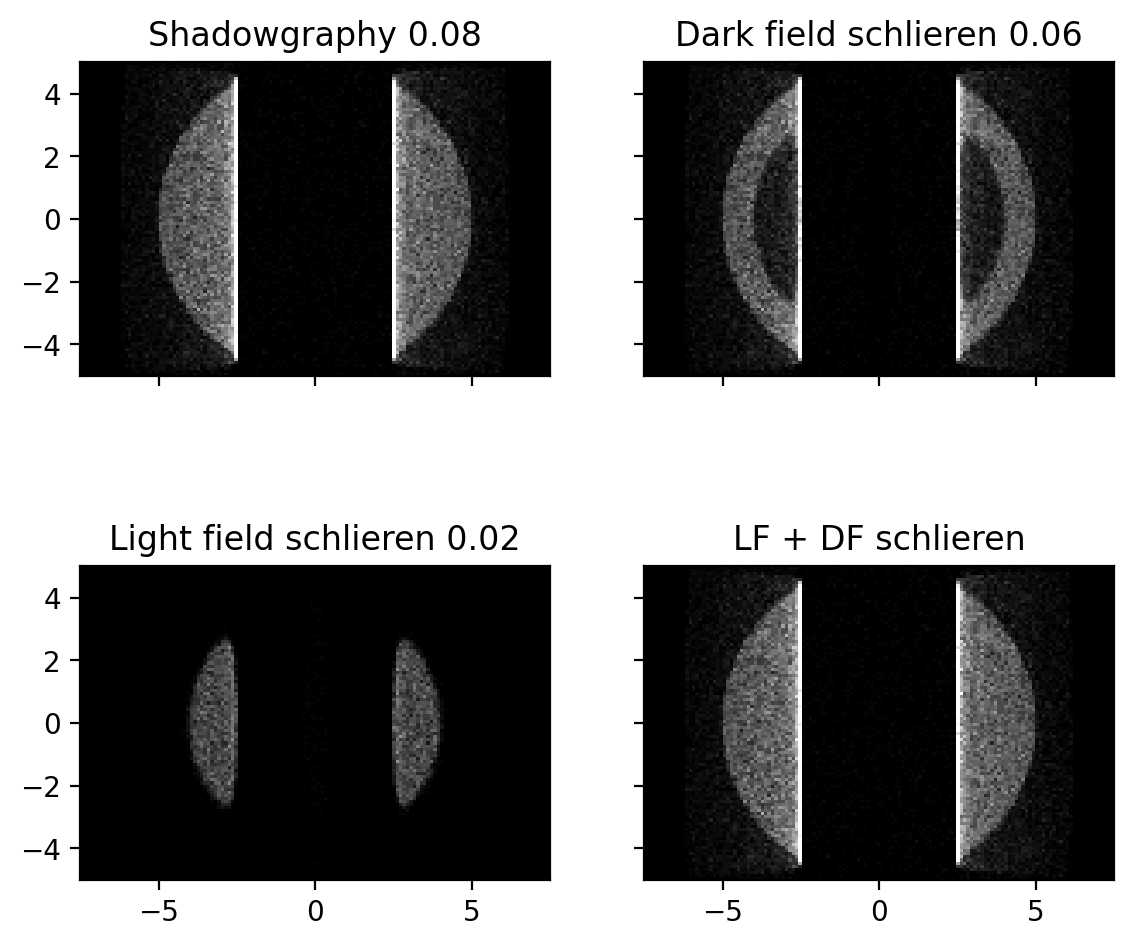

In [83]:
sh.histogram(bin_scale = 25)
sc_df.histogram(bin_scale = 25)
sc_lf.histogram(bin_scale = 25)

fig, axs = plt.subplots(2,2, figsize=(6.67, 6), sharex = True, sharey = True, dpi = 200)

cm='gray'
clim=[0,50]

sh.plot(axs[0,0], clim=clim, cmap=cm)
axs[0,0].set_title('Shadowgraphy {:.2f}'.format(sh.H.sum()/1e6))
sc_df.plot(axs[0,1], clim=clim, cmap=cm)
axs[0,1].set_title('Dark field schlieren {:.2f}'.format(sc_df.H.sum()/1e6))
sc_lf.plot(axs[1,0], clim=clim, cmap=cm)
axs[1,0].set_title('Light field schlieren {:.2f}'.format(sc_lf.H.sum()/1e6))

axs[1,1].imshow(sc_lf.H+sc_df.H, interpolation='nearest', origin='lower', clim=clim, cmap=cm,
                extent=[sh.xedges[0], sh.xedges[-1], sh.yedges[0], sh.yedges[-1]])
axs[1,1].set_title('LF + DF schlieren')

Note that I have used very short focal length lenses with a huge NA to capture light here: many of the rays are lost.

## AFR

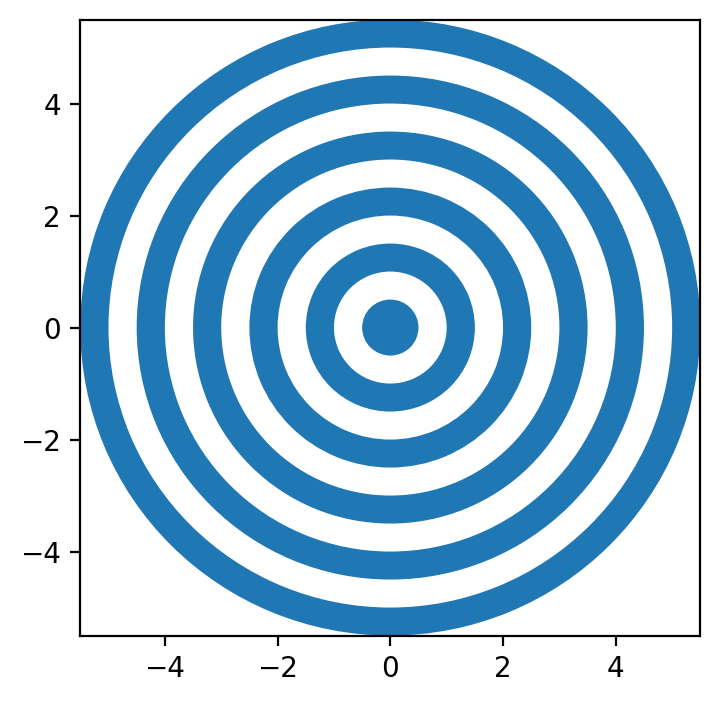

In [88]:
Rs = np.arange(0, 6, 0.5)
f, a = rtm.plot_afr(Rs)

afr = rtm.AFR(r0 = rf, focal_plane = 5, L=100, R=25, Lx=15, Ly=10)
afr.solve(Rs)

Text(0.5, 1.0, 'AFR 0.02')

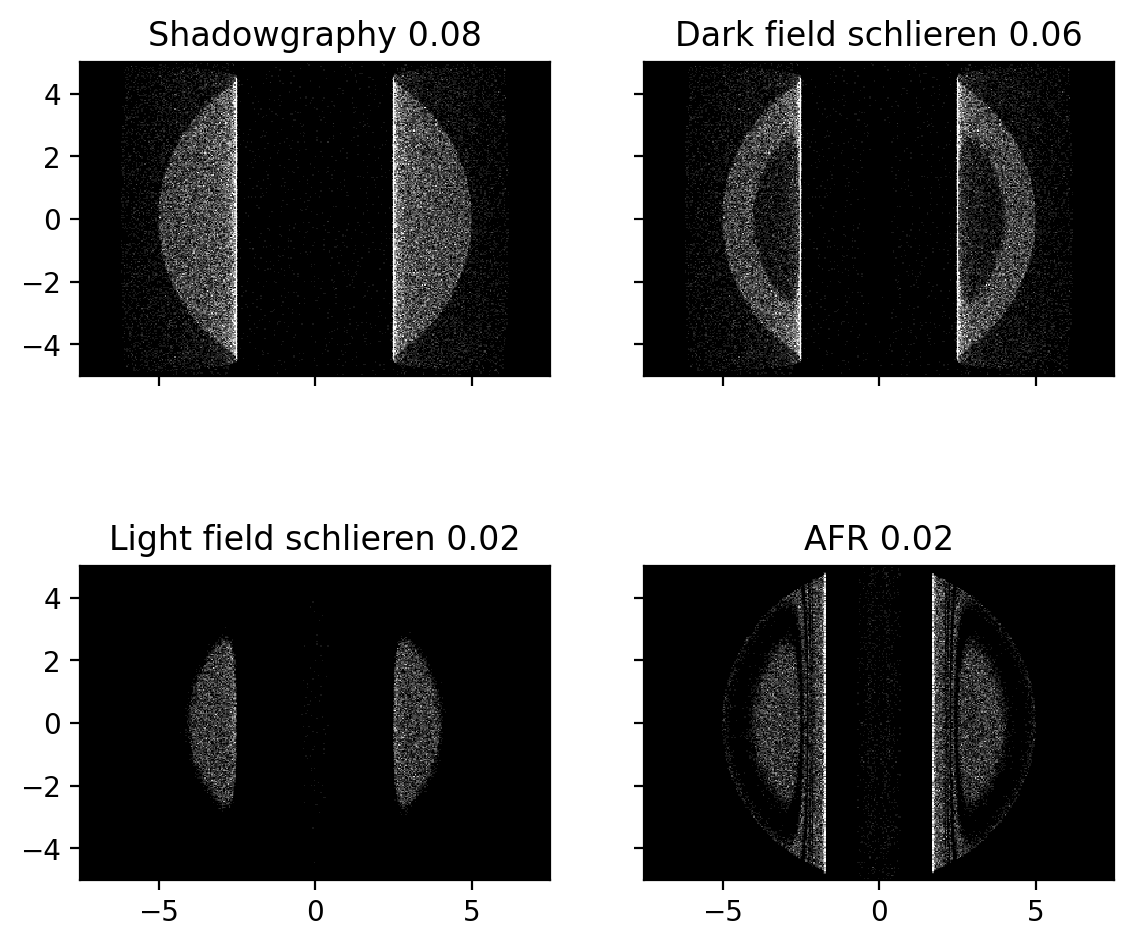

In [93]:
sh.histogram(bin_scale = 10)
sc_df.histogram(bin_scale = 10)
sc_lf.histogram(bin_scale = 10)
afr.histogram(bin_scale = 10)

fig, axs = plt.subplots(2,2, figsize=(6.67, 6), sharex = True, sharey = True, dpi = 200)

cm='gray'
clim=[0,10]

sh.plot(axs[0,0], clim=clim, cmap=cm)
axs[0,0].set_title('Shadowgraphy {:.2f}'.format(sh.H.sum()/1e6))
sc_df.plot(axs[0,1], clim=clim, cmap=cm)
axs[0,1].set_title('Dark field schlieren {:.2f}'.format(sc_df.H.sum()/1e6))
sc_lf.plot(axs[1,0], clim=clim, cmap=cm)
axs[1,0].set_title('Light field schlieren {:.2f}'.format(sc_lf.H.sum()/1e6))
afr.plot(axs[1,1], clim=clim, cmap=cm)
axs[1,1].set_title('AFR {:.2f}'.format(sc_lf.H.sum()/1e6))

## Load simulation data


In [307]:
n_e = np.load('x01_rnec-300.npy')

n = np.rot90(n_e, axes = (2,1))

x = np.arange(-5e-3,5e-3,50e-6)
y = np.arange(-3e-3,3e-3,50e-6)
z = np.arange(-10e-3,10e-3,50e-6)

shock = pt.ElectronCube(x,y,z)
shock.external_ne(n)
shock.calc_dndr()

### Initialise rays
shock.init_beam(Np = 1000000, beam_size= 3e-3, divergence = 0)

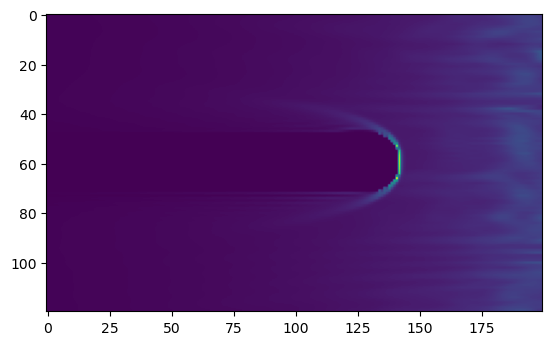

In [168]:
fig, ax = plt.subplots()
ax.imshow(n[:,:, n.shape[2]//2].T) #use .T to transform so first axis is plotted horizontal

In [309]:
shock.solve()
s0 = shock.s0
rf = shock.rf

shock.save_output_rays('rays')

Ray trace completed in:	 1273.978144645691 s


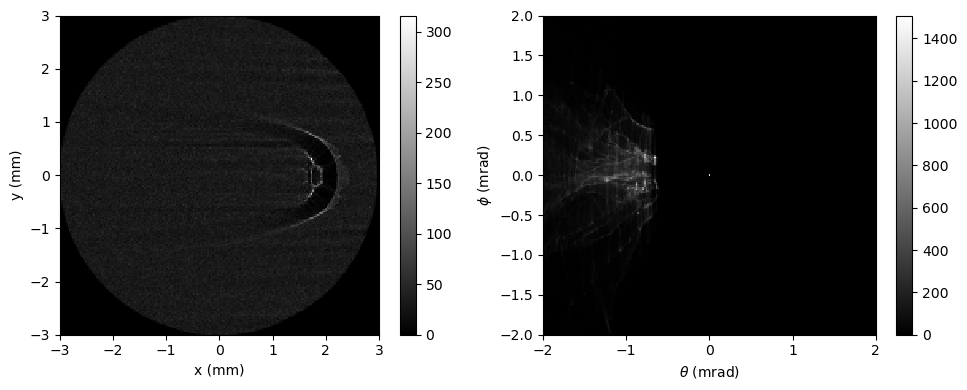

In [321]:
## Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
nbins = 201

_,_,_,im1 = ax1.hist2d(rf[0]*1e3, rf[2]*1e3, bins=(nbins, nbins), range = ((-3,3), (-3,3)), cmap=plt.cm.gray);
plt.colorbar(im1,ax=ax1)
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_aspect('equal')

_,_,_,im2 = ax2.hist2d(rf[1]*1e3, rf[3]*1e3, bins=(nbins, nbins), range = ((-2,2), (-2,2)), cmap=plt.cm.gray);
plt.colorbar(im2,ax=ax2)
ax2.set_xlabel(r"$\theta$ (mrad)")
ax2.set_ylabel(r"$\phi$ (mrad)")
ax1.set_aspect('equal')

fig.tight_layout()

In [ ]:
rf = np.open('rays.npy')

In [329]:
sh = rtm.Shadowgraphy(r0 = rf, focal_plane = 0, L=400, R=25, Lx=6, Ly=6)
sc_df = rtm.Schlieren_DF(r0 = rf, focal_plane = 0, L=400, R=25, Lx=6, Ly=6)
sc_lf = rtm.Schlieren_LF(r0 = rf, focal_plane = 0, L=400, R=25, Lx=6, Ly=6)

In [330]:
sh.solve()
sc_df.solve()
sc_lf.solve()

Text(0.5, 1.0, 'LF + DF schlieren')

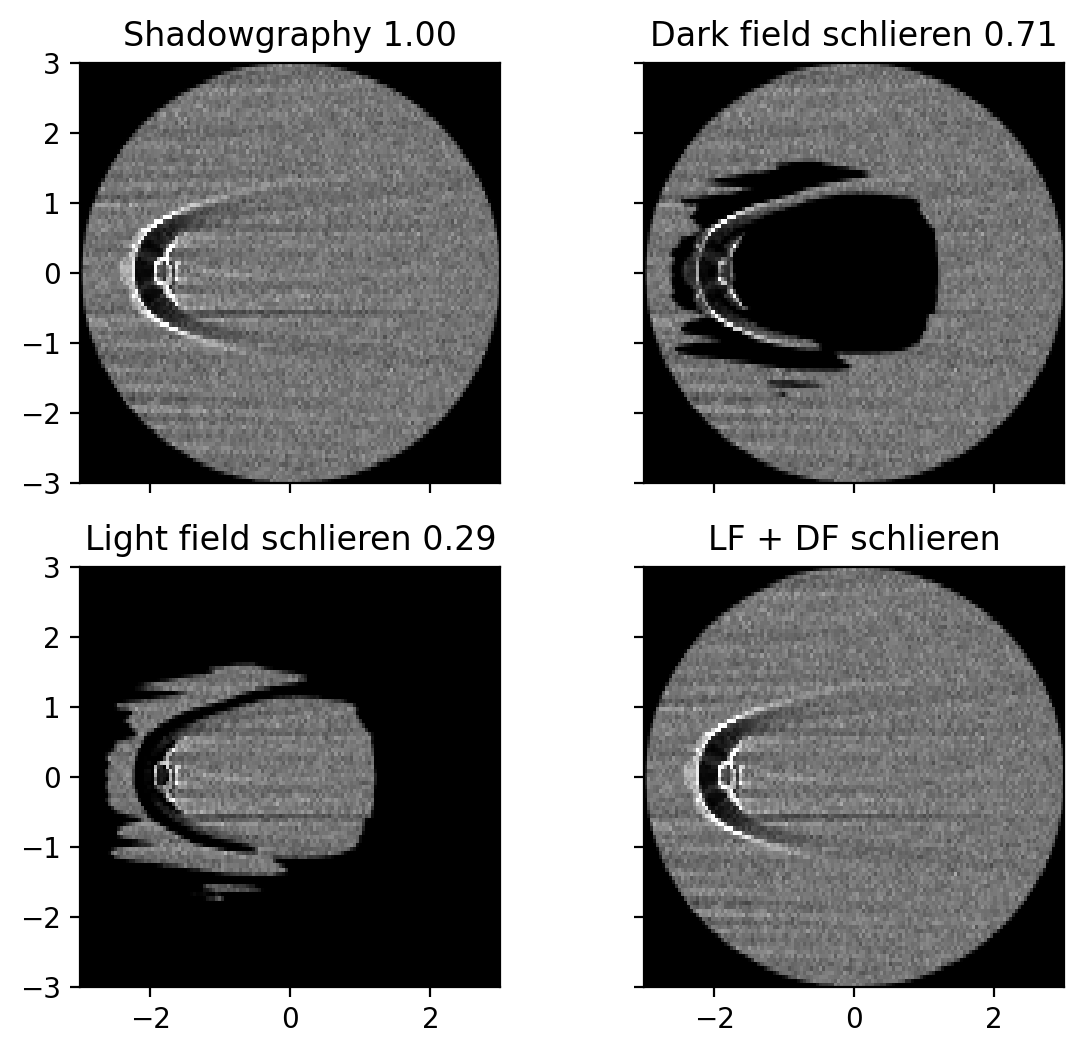

In [331]:
sh.histogram(bin_scale = 25)
sc_df.histogram(bin_scale = 25)
sc_lf.histogram(bin_scale = 25)

fig, axs = plt.subplots(2,2, figsize=(6.67, 6), sharex = True, sharey = True, dpi = 200)

cm='gray'
clim=[0,200]

NR = rf.shape[1]

sh.plot(axs[0,0], clim=clim, cmap=cm)
axs[0,0].set_title('Shadowgraphy {:.2f}'.format(sh.H.sum()/NR))
sc_df.plot(axs[0,1], clim=clim, cmap=cm)
axs[0,1].set_title('Dark field schlieren {:.2f}'.format(sc_df.H.sum()/NR))
sc_lf.plot(axs[1,0], clim=clim, cmap=cm)
axs[1,0].set_title('Light field schlieren {:.2f}'.format(sc_lf.H.sum()/NR))

axs[1,1].imshow(sc_lf.H+sc_df.H, interpolation='nearest', origin='lower', clim=clim, cmap=cm,
                extent=[sh.xedges[0], sh.xedges[-1], sh.yedges[0], sh.yedges[-1]])
axs[1,1].set_title('LF + DF schlieren')